# 1. Install Dependencies and Setup

In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.1.0
anyio                     4.4.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2024.7.4
cffi                      1.17.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.5
decorator                 5.1.1
defusedxml                0.7.1
executing                 2.0.1
fastjsonschema            2.20.0
flatbuffers               24.3.25
fonttools                 4.53.1
fqdn                      1.5.1
gast                      0.6.0
google-pasta   

In [55]:
import tensorflow as tf
import os

In [56]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [57]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [58]:
import cv2
import imghdr

In [59]:
data_dir = 'data' 

In [60]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [61]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [62]:
import numpy as np
from matplotlib import pyplot as plt

In [63]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [64]:
data_iterator = data.as_numpy_iterator()

In [65]:
batch = data_iterator.next()

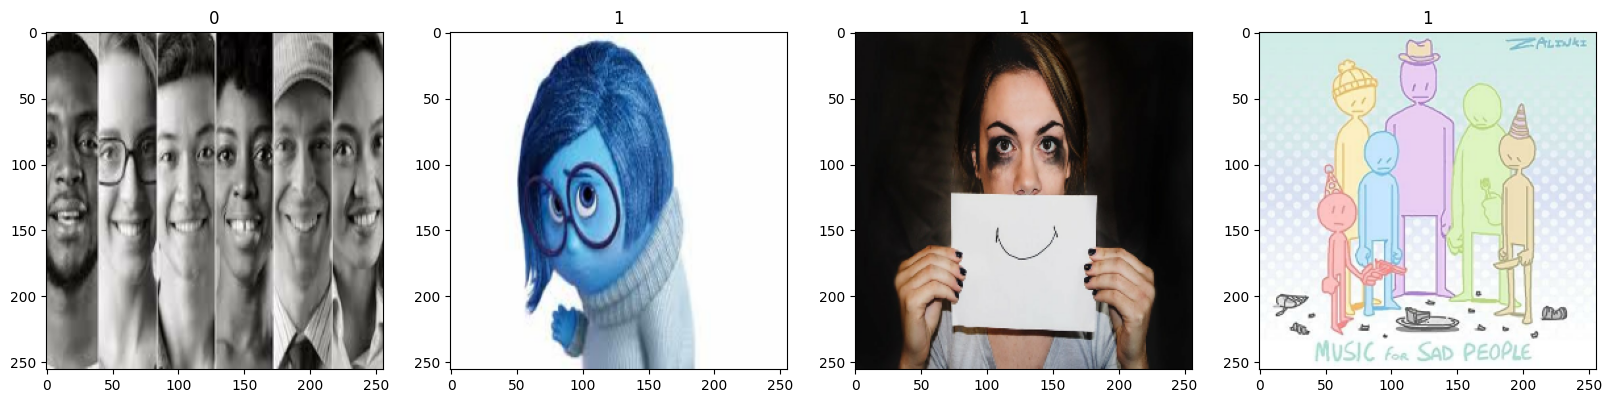

In [66]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [68]:
data = data.map(lambda x,y: (x/255, y))

In [69]:
data.as_numpy_iterator().next()

(array([[[[0.77254903, 0.33333334, 0.32941177],
          [0.7816483 , 0.3353554 , 0.32671568],
          [0.8230086 , 0.34454656, 0.31446078],
          ...,
          [0.68308824, 0.6984069 , 0.68477327],
          [0.69534314, 0.7045343 , 0.6924326 ],
          [0.69803923, 0.7058824 , 0.69411767]],
 
         [[0.7752451 , 0.32591912, 0.32637867],
          [0.78501046, 0.3288969 , 0.32455146],
          [0.8293986 , 0.34243235, 0.31624588],
          ...,
          [0.6768957 , 0.69271195, 0.6816138 ],
          [0.68704426, 0.6966014 , 0.6871668 ],
          [0.68927693, 0.69745713, 0.68838847]],
 
         [[0.7875    , 0.29221815, 0.3125919 ],
          [0.8002932 , 0.2995402 , 0.314714  ],
          [0.85844415, 0.33282232, 0.32435998],
          ...,
          [0.6487477 , 0.66682583, 0.6672526 ],
          [0.64932215, 0.6605428 , 0.6632315 ],
          [0.6494485 , 0.65916055, 0.66234684]],
 
         ...,
 
         [[0.2963848 , 0.26145834, 0.36302084],
          [0.30086

# 5. Split Data

In [70]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [71]:
train_size

7

In [72]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [73]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [75]:
model = Sequential()

In [76]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [77]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape      ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)        │ (None, 254, 254,  │        448 │
│                          │ 16)               │            │
├──────────────────────────┼───────────────────┼────────────┤
│ max_pooling2d_3          │ (None, 127, 127,  │          0 │
│ (MaxPooling2D)           │ 16)               │            │
├──────────────────────────┼───────────────────┼────────────┤
│ conv2d_4 (Conv2D)        │ (None, 125, 125,  │      4,640 │
│                          │ 32)               │            │
├──────────────────────────┼───────────────────┼────────────┤
│ max_pooling2d_4          │ (None, 62, 62,    │          0 │
│ (MaxPooling2D)           │ 32)               │            │
├──────────────────────────┼───────────────────┼────────────┤
│ conv2d_5 (Conv2D)        │ (None, 60, 60,    │      4,624 │
│                          │ 16)               │            │
├──────────────────────────┼───────────────────┼────────────┤
│ max_pooling2d_5          │ (None, 30, 30,    │          0 │
│ (MaxPooling2D)           │ 16)               │            │
├──────────────────────────┼───────────────────┼────────────┤
│ flatten_1 (Flatten)      │ (None, 14400)     │          0 │
├──────────────────────────┼───────────────────┼────────────┤
│ dense_2 (Dense)          │ (None, 256)       │  3,686,656 │
├──────────────────────────┼───────────────────┼────────────┤
│ dense_3 (Dense)          │ (None, 1)         │        257 │
└──────────────────────────┴───────────────────┴────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [79]:
logdir='logs'

In [80]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4594 - loss: 1.1551 - val_accuracy: 0.5469 - val_loss: 0.6916
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4713 - loss: 0.6975 - val_accuracy: 0.7188 - val_loss: 0.6271
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6893 - loss: 0.6156 - val_accuracy: 0.7812 - val_loss: 0.5411
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7485 - loss: 0.5836 - val_accuracy: 0.7344 - val_loss: 0.5009
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8108 - loss: 0.4774 - val_accuracy: 0.7500 - val_loss: 0.4645
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8113 - loss: 0.4221 - val_accuracy: 0.8594 - val_loss: 0.3060
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8477 - loss: 0.3652 - val_accuracy: 0.9375 - val_loss: 0.3076
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9175 - loss: 0.2883 - val_accuracy: 0.8906 - val_loss: 0.2286
Epoch 9/20

# 8. Plot Performance

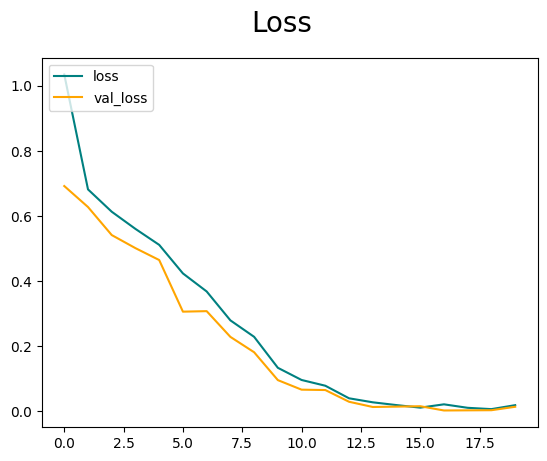

In [82]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

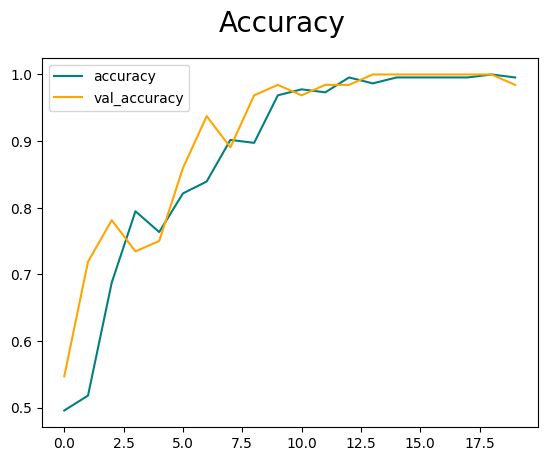

In [83]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [84]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [85]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [86]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


In [87]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [88]:
import cv2

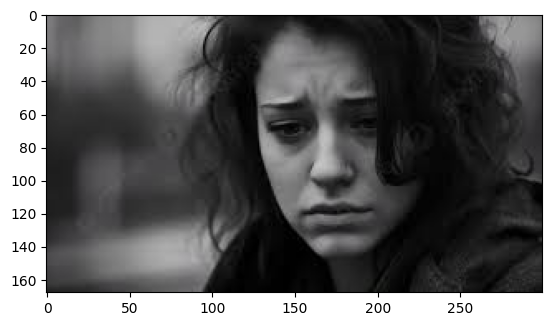

In [89]:
img = cv2.imread('images.jpeg')
plt.imshow(img)
plt.show()

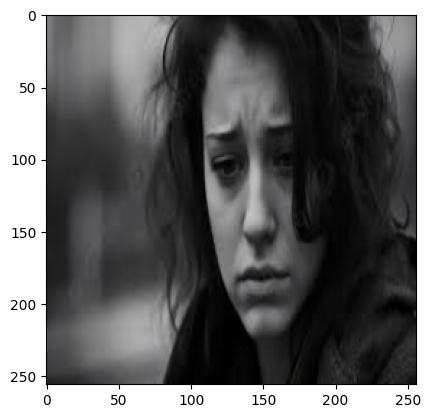

In [90]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [91]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [92]:
yhat

array([[0.9899302]], dtype=float32)

In [93]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [98]:
from tensorflow.keras.models import load_model

In [103]:
# Liste les fichiers dans le répertoire actuel pour vérifier la présence du fichier
print(os.listdir())

['.gitignore', '.ipynb_checkpoints', '154006829.jpg', '1865153395.jpg', '8iAb9k4aT.jpg', 'data', 'Getting Started.ipynb', 'ImageClassification', 'images.jpeg', 'logs', 'models']


In [109]:
model.save('imageclassifier.h5')

In [106]:
model.save(os.path.join('ImageClassification/models','imageclassifier.h5'))

In [110]:
from tensorflow.keras.models import load_model
new_model = load_model('imageclassifier.h5')

In [112]:
yhat = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [111]:
import numpy as np
# Supposez que 'resize' est votre image redimensionnée
yhat = new_model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[[0.9899302]]
Predicted class is Sad
